In [1]:
import pandas as pd
import numpy as np
import bilby
import lal
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import copy

import sys
sys.path.append("..")

from create_post_dict import create_post_dict
from waveforms import mem_freq_XPHM, mem_freq_XPHM_only

events_name = 'GW170818' 
file_path = '/home/shunyin.cheung/GWOSC_posteriors/IGWN-GWTC2p1-v2-GW170818_022509_PEDataRelease_mixed_cosmo.h5'
waveform = "C01:IMRPhenomXPHM"
data_file = None

samples, meta_dict, config_dict, priors, psds, calibration = create_post_dict(file_path, waveform)

logger = bilby.core.utils.logger

sampling_frequency = 2048
maximum_frequency = 1024
minimum_frequency = 20
reference_frequency = 20
roll_off = 0.4
duration = 4
post_trigger_duration = 2
trigger_time = 1187058327.081509
detectors = ['L1']

end_time = trigger_time + post_trigger_duration
start_time = end_time - duration
print('start time = ', start_time)
print('end time = ', end_time)
logger = bilby.core.utils.logger

ifo_list = bilby.gw.detector.InterferometerList([])

for det in detectors:   
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    ifo.strain_data.roll_off = roll_off
    
    channel = f"L1:DCH-CLEAN_STRAIN_C02"
    
    kwargs = dict(
        start=start_time,
        end=end_time,
        verbose=False,
        allow_tape=True,
    )

    type_kwargs = dict(
        dtype="float64",
        subok=True,
        copy=False,
    )
    data = gwpy.timeseries.TimeSeries.get(channel, **kwargs).astype(
            **type_kwargs)

    # logger.info("Attempting to download data from GWOSC")
    # kwargs = dict(ifo=det, start=start_time, end=end_time)
    # data = gwpy.timeseries.TimeSeries.fetch_open_data(**kwargs)
    
    # Resampling timeseries to sampling_frequency using lal.
    lal_timeseries = data.to_lal()
    lal.ResampleREAL8TimeSeries(
        lal_timeseries, float(1/sampling_frequency)
    )
    data = TimeSeries(
        lal_timeseries.data.data,
        epoch=lal_timeseries.epoch,
        dt=lal_timeseries.deltaT
    )

    # define some attributes in ifo
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    
    # set data as the strain data
    ifo.strain_data.set_from_gwpy_timeseries(data)
    
    # compute the psd
    if det in psds.keys():
        print("Using pre-computed psd from results file")
        print(psds)
        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psds[det][: ,0], psd_array=psds[det][:, 1]
        )
    else:
        print('Error: PSD is missing!')
        exit()

    ifo_list.append(ifo)

interferometer = ifo_list[0]


KeyboardInterrupt: 

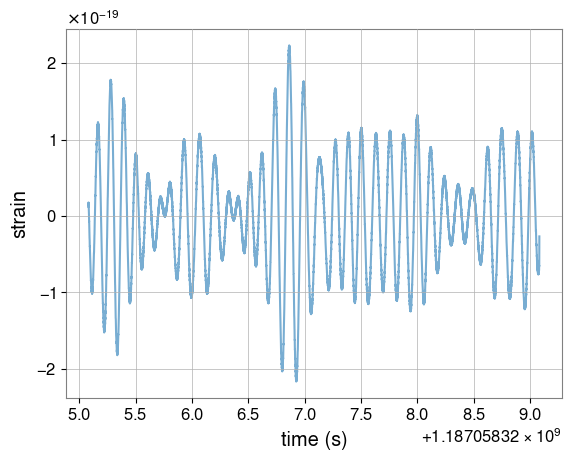

In [3]:
plt.plot(data.times, data, label='L1', alpha=0.6)
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.show()

In [48]:
from gwpy.signal.filter_design import bandpass, concatenate_zpks, notch


td_H1 = ifo_list[0].time_domain_strain
times2 = ifo_list[0].time_array

timeseries = TimeSeries(
            data=td_H1, times=times2)


bandpass_frequencies=(50, 250)

zpks = []

zpks.append(bandpass(
                bandpass_frequencies[0], bandpass_frequencies[1],
                sampling_frequency))
zpk = concatenate_zpks(*zpks)
strain_H1 = timeseries.filter(zpk, filtfilt=False)

TypeError: bandpass() missing 1 required positional argument: 'sample_rate'

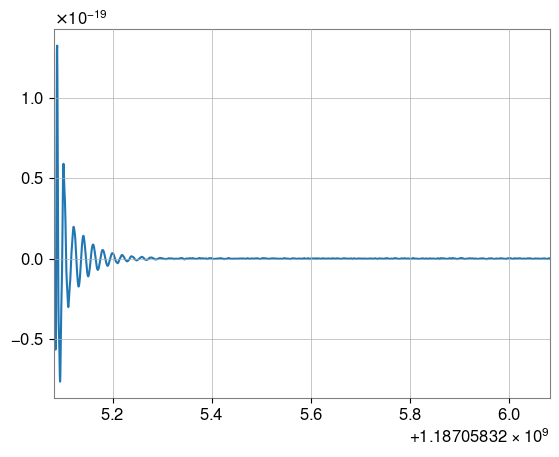

In [6]:
plt.plot(strain_H1.times, strain_H1.value, label='H1')
plt.xlim(trigger_time-2, trigger_time-1)
plt.show()

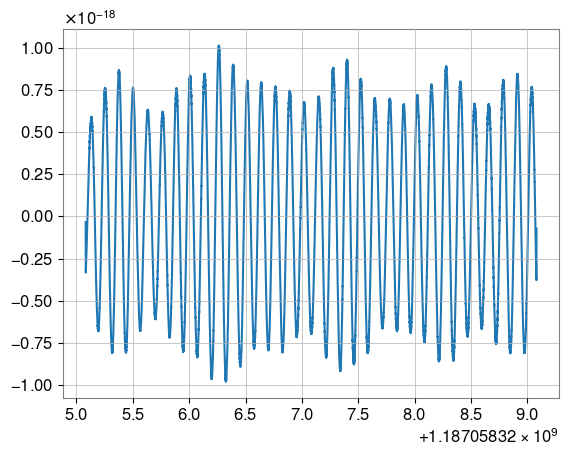

In [8]:
plt.plot(interferometer.time_array, interferometer.time_domain_strain)
plt.show()

/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


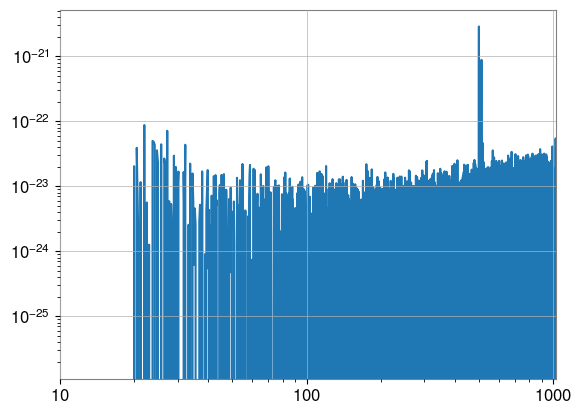

In [5]:
plt.figure()
plt.loglog(interferometer.frequency_array, interferometer.frequency_domain_strain, label='strain')
#plt.loglog(interferometer.frequency_array, interferometer.whitened_frequency_domain_strain, label='whitened strain')
plt.xlim(10, 1024)
plt.show()

plt.figure()
plt.loglog(interferometer.frequency_array, interferometer.whitened_frequency_domain_strain, label='whitened strain')
plt.xlim(10, 1024)
plt.xlabel('frequency (Hz)')
plt.show()

In [2]:
amplitude = 1000
print('amplitude = ',amplitude)

waveform_name = 'IMRPhenomXPHM'

priors2 = copy.copy(priors)

# test if bilby oscillatory waveform = gwmemory oscillatory waveform.
waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)

# define oscillatory + memory model using gwmemory.
waveform_generator_full = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

waveform_generator_mem = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM_only,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

target_likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator_osc,
    time_marginalization = True,
    distance_marginalization = True,
    distance_marginalization_lookup_table = '../TD.npz',
    jitter_time=True,
    priors = priors2,
    reference_frame = 'H1L1',
    time_reference = 'geocent',
)

22:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
22:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_v2
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
22:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_only
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


amplitude =  1000


22:07 bilby INFO    : Loaded distance marginalisation lookup table from ../TD.npz.


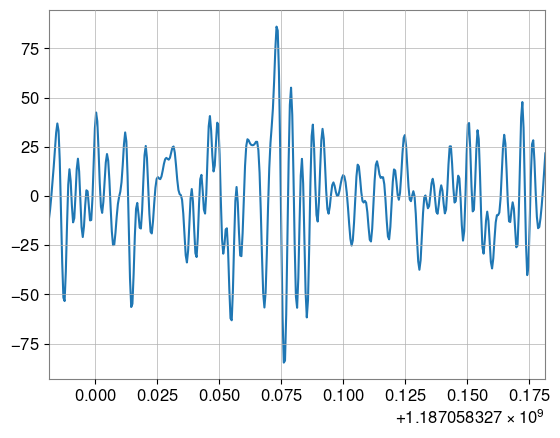

: 

In [3]:
from bilby.core.utils.series import infft

whitened = np.array(copy.copy(interferometer.whitened_frequency_domain_strain))
whitened[interferometer.frequency_array>300] = 0

fd_strain = interferometer.whitened_frequency_domain_strain

td_strain = infft(whitened, sampling_frequency = 2048)

time = interferometer.time_array

plt.figure()
plt.plot(time, td_strain)
plt.xlim(trigger_time-0.1, trigger_time+0.1)
plt.show()

max_like = np.argmax(samples['log_likelihood'])
posterior = samples.iloc[max_like].to_dict()

frequency_domain_strain_osc = interferometer.get_detector_response(waveform_generator_osc.frequency_domain_strain(posterior), 
                                                                   posterior)

frequency_domain_strain_full = interferometer.get_detector_response(waveform_generator_full.frequency_domain_strain(posterior), 
                                                                   posterior)
frequency_domain_strain_mem = interferometer.get_detector_response(waveform_generator_mem.frequency_domain_strain(posterior), 
                                                                   posterior)



fd_strain_osc = frequency_domain_strain_osc/interferometer.power_spectral_density_array**0.5
fd_strain_full = frequency_domain_strain_full/interferometer.power_spectral_density_array**0.5
fd_strain_mem = frequency_domain_strain_mem/interferometer.power_spectral_density_array**0.5
# plt.figure()
# plt.loglog(waveform_generator_osc.frequency_array, fd_strain_total)
# plt.show()
time_domain_strain_osc = bilby.core.utils.series.infft(fd_strain_osc, sampling_frequency=2048)
time_domain_strain_full = bilby.core.utils.series.infft(fd_strain_full, sampling_frequency=2048)
time_domain_strain_mem = bilby.core.utils.series.infft(fd_strain_mem, sampling_frequency=2048)

time_array = waveform_generator_osc.time_array

plt.figure()
plt.title('A=100')
plt.plot(time, td_strain, label='whitened L1 data')
plt.plot(time_array, np.roll(time_domain_strain_osc,0), label='osc waveform')
plt.plot(time_array, np.roll(time_domain_strain_full,0), label='full waveform')
plt.plot(time_array, np.roll(time_domain_strain_mem,0), label='mem waveform')
plt.xlim(trigger_time-0.1, trigger_time+0.1)
plt.xlabel
plt.legend()
plt.show()

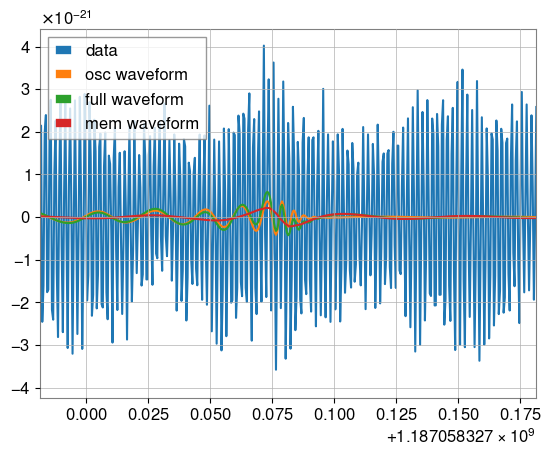

In [38]:
max_like = np.argmax(samples['log_likelihood'])
posterior = samples.iloc[max_like].to_dict()

from bilby.core.utils.series import infft

fd_strain = interferometer.frequency_domain_strain
td_strain = infft(fd_strain, sampling_frequency = 2048)

time = interferometer.time_array

frequency_domain_strain_osc = interferometer.get_detector_response(waveform_generator_osc.frequency_domain_strain(posterior), 
                                                                   posterior)
frequency_domain_strain_full = interferometer.get_detector_response(waveform_generator_full.frequency_domain_strain(posterior), 
                                                                   posterior)
frequency_domain_strain_mem = interferometer.get_detector_response(waveform_generator_mem.frequency_domain_strain(posterior), 
                                                                   posterior)

time_domain_strain_osc = bilby.core.utils.series.infft(frequency_domain_strain_osc, sampling_frequency=2048)
time_domain_strain_full = bilby.core.utils.series.infft(frequency_domain_strain_full, sampling_frequency=2048)
time_domain_strain_mem = bilby.core.utils.series.infft(frequency_domain_strain_mem, sampling_frequency=2048)

time_array = waveform_generator_osc.time_array

plt.figure()
plt.plot(time, td_strain, label='data')
#plt.plot(time_array, np.roll(8e22*(time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross']), -4096), label='waveform')
plt.plot(time_array, np.roll(time_domain_strain_osc,0), label='osc waveform')
plt.plot(time_array, np.roll(time_domain_strain_full,0), label='full waveform')
plt.plot(time_array, np.roll(time_domain_strain_mem,0), label='mem waveform')
plt.xlim(trigger_time-0.1, trigger_time+0.1)
plt.xlabel
plt.legend()
plt.show()

In [23]:
interferometer.plot_data(outdir='tests', label='asd')

19:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
19:59 bilby INFO    : Injected signal in H1:
19:59 bilby INFO    :   optimal SNR = 27.88
19:59 bilby INFO    :   matched filter SNR = 28.58+0.85j
19:59 bilby INFO    :   mass_1 = 35.3
19:59 bilby INFO    :   mass_2 = 29.6
19:59 bilby INFO    :   a_1 = 0.34
19:59 bilby INFO    :   a_2 = 0.32
19:59 bilby INFO    :   luminosity_distance = 410
19:59 bilby INFO    :   theta_jn = 1.5707963267948966
19:59 bilby INFO    :   psi = 2.659
19:59 bilby INFO    :   phase = 1.3
19:59 bilby INFO    :   geocent_time = 1126259642.413
19:59 bilby INFO    :   ra = 1.375
19:59 bilby INFO    :   dec = -1.2108
19:59 bilby INFO    :   tilt_1 = 0.79
19:59 bilby INFO    :   tilt_2 = 2.36
19:59 bilby INFO    :   phi_12 = 0.4
19:59 bilby INFO    :   phi_jl = 0.4


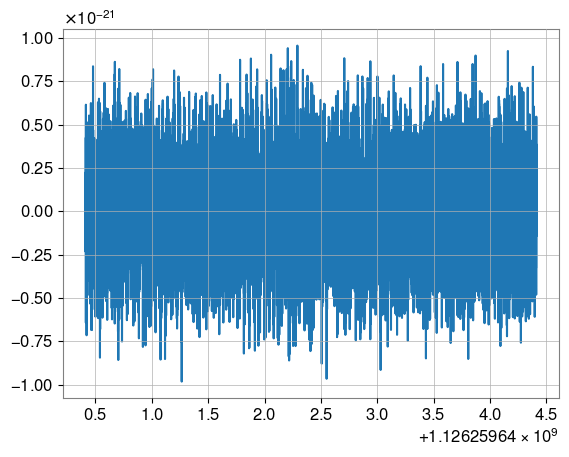

In [52]:
injection_parameters = dict(
    mass_1=35.3,
    mass_2=29.6,
    a_1=0.34,
    a_2=0.32,
    luminosity_distance=410,
    theta_jn=np.pi/2,
    psi=2.659,                   
    phase=1.3,               
    geocent_time=1126259642.413,
    ra=1.375,                
    dec=-1.2108,
    tilt_1 = 0.79,
    tilt_2 = 2.36,
    phi_12 = 0.4,
    phi_jl = 0.4,
)

duration = 4
sampling_frequency = 4096
start_time = injection_parameters["geocent_time"] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
# Note that the EoS sampling is agnostic to waveform model as long as the approximant
# can include tides.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomXPHM",
    reference_frequency=20.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

# Set up interferometers.
interferometers = bilby.gw.detector.InterferometerList(["H1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 20
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

plt.figure()
plt.plot(interferometer.time_array, interferometer.time_domain_strain)
plt.show()